# Importing Libraries

In [ ]:
#Install kaggle API client
!pip install -q kaggle
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd
import os
import zipfile
import random
import shutil
import cv2
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Downloading Dataset

In [ ]:
mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aditisatsangi/dataset-indian-vehicles
!unzip \*.zip && rm *.zip

 99% 905M/913M [00:11<00:00, 58.5MB/s]
100% 913M/913M [00:11<00:00, 84.1MB/s]
Archive:  dataset-indian-vehicles.zip
  inflating: Vehicles./Vehicles/Auto/Thumbs.db  
  inflating: Vehicles./Vehicles/Auto/img 0100.PNG  
  inflating: Vehicles./Vehicles/Auto/img 0127.jpg  
  inflating: Vehicles./Vehicles/Auto/img 095.PNG  
  inflating: Vehicles./Vehicles/Auto/img 096.PNG  
  inflating: Vehicles./Vehicles/Auto/img 097.PNG  
  inflating: Vehicles./Vehicles/Auto/img 098.PNG  
  inflating: Vehicles./Vehicles/Auto/img 099.PNG  
  inflating: Vehicles./Vehicles/Auto/img 101.PNG  
  inflating: Vehicles./Vehicles/Auto/img 102.PNG  
  inflating: Vehicles./Vehicles/Auto/img 103.PNG  
  inflating: Vehicles./Vehicles/Auto/img 104.PNG  
  inflating: Vehicles./Vehicles/Auto/img 105.PNG  
  inflating: Vehicles./Vehicles/Auto/img 106.PNG  
  inflating: Vehicles./Vehicles/Auto/img 107.PNG  
  inflating: Vehicles./Vehicles/Auto/img 108.jpg  
  inflating: Vehicles./Vehicles/Auto/img 109.PNG  
  inflating: Vehi

In [ ]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

# Training and Validation Dataset

In [ ]:
class_names = ['Auto', 'Bus','Car','Truck']
# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   validation_split=0.2  # Split the dataset into training and validation
)

data = datagen.flow_from_directory(
   '/content/Vehicles./Vehicles',
   target_size=(224, 224),
   batch_size=BATCH_SIZE,
   #validation_split=0.2,
   subset='training',  # Specify 'training' to get the training subset
   seed=42,
   class_mode='categorical'  # Return class names as labels
)

class_names = data.class_indices

Found 2130 images belonging to 4 classes.


In [ ]:
class_indices = data.class_indices
print(class_indices)

{'Auto': 0, 'Bus': 1, 'Car': 2, 'Truck': 3}


In [ ]:
import os
import shutil
IMAGE_RES = 224
BATCH_SIZE = 32

data_dir = '/content/Vehicles./Vehicles'
# Create training, validation, and testing directories
train_dir = '/content/Vehicles./train'
val_dir = '/content/Vehicles./val'
test_dir = '/content/Vehicles./test'

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to split data into train, validation, and test sets
def split_data(class_folder, source, destination):
    os.makedirs(destination, exist_ok=True)
    files = os.listdir(os.path.join(data_dir, class_folder))
    num_files = len(files)

    train_split = int(0.8 * num_files)
    val_split = int(0.1 * num_files)

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    for file in train_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'train', class_folder, file))

    for file in val_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'val', class_folder, file))

    for file in test_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'test', class_folder, file))

# Move data to train, validation, and test directories
for class_folder in os.listdir(data_dir):
    split_data(class_folder, data_dir, '/content/Vehicles.')

# Now use flow_from_directory on the separate train, val, and test directories
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

Found 2470 images belonging to 4 classes.
Found 94 images belonging to 4 classes.
Found 97 images belonging to 4 classes.


# Labelling dataset

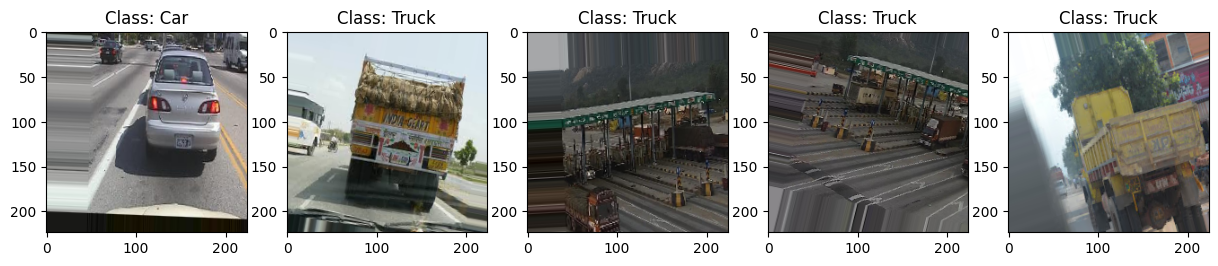

In [ ]:
import matplotlib.pyplot as plt

# Load the first batch of data (batch size = 32)
batch = next(data)

# Get the first 5 images and their one-hot encoded labels
images, one_hot_labels = batch[0][:5], batch[1][:5]

# Set the figure size for larger images
plt.figure(figsize=(15, 5))

# Iterate through the images and labels
for i in range(5):
    # Find the class index (1 in one-hot encoding)
    class_index = list(one_hot_labels[i]).index(1)

    # Get the class name from the class index
    class_name = list(data.class_indices.keys())[list(data.class_indices.values()).index(class_index)]

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Class: {class_name}')

plt.show()

In [ ]:
for i in range(1):  # Preview the first batch
    batch = next(data)
    images, labels = batch
    # Process or display the images and labels as needed
    print(labels)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 32

# Using Pretrained Model MobileNet

In [ ]:
# Load the MobileNetV2 model with pre-trained weights
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top (classification) layers
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model's layers (optional)
base_model.trainable = False

num_classes = len(class_names)  # Number of classes
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class

# Update the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    output_layer  # Updated output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484

# Training Model

In [ ]:
batch_size=32
# Define the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
66/66 [==============================] - 179s 3s/step - loss: 0.3397 - accuracy: 0.8866 - val_loss: 0.2294 - val_accuracy: 0.9219
Epoch 2/10
66/66 [==============================] - 165s 2s/step - loss: 0.1241 - accuracy: 0.9576 - val_loss: 0.1417 - val_accuracy: 0.9473
Epoch 3/10
66/66 [==============================] - 163s 2s/step - loss: 0.1008 - accuracy: 0.9638 - val_loss: 0.1520 - val_accuracy: 0.9512
Epoch 4/10
66/66 [==============================] - 148s 2s/step - loss: 0.0664 - accuracy: 0.9809 - val_loss: 0.1220 - val_accuracy: 0.9590
Epoch 5/10
66/66 [==============================] - 148s 2s/step - loss: 0.0679 - accuracy: 0.9752 - val_loss: 0.1554 - val_accuracy: 0.9531
Epoch 6/10
66/66 [==============================] - 162s 2s/step - loss: 0.0656 - accuracy: 0.9738 - val_loss: 0.2076 - val_accuracy: 0.9551
Epoch 7/10
66/66 [==============================] - 148s 2s/step - loss: 0.0595 - accuracy: 0.9809 - val_loss: 0.1052 - val_accuracy: 0.9609
Epoch 8/10
66

# Accuracy

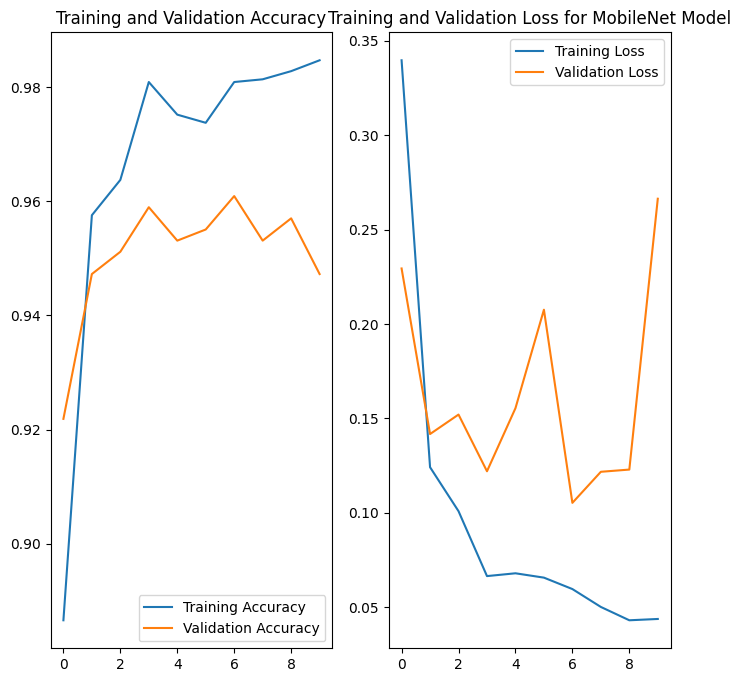

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=10
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f' Loss: {validation_loss:.4f}')
print(f' Accuracy: {validation_accuracy*100:.2f}%')

17/17 [==============================] - 35s 2s/step - loss: 0.2682 - accuracy: 0.9360
 Loss: 0.2682
 Accuracy: 93.60%


In [ ]:
# Save the trained model
model.save('vehicle_classification_model_MobileneN.h5')

# Prediction

In [ ]:
class_names = ['Auto', 'Bus','Car','Truck']

1/1 [==============================] - 2s 2s/step
1: moving_van (0.79)
2: trailer_truck (0.10)
3: recreational_vehicle (0.02)


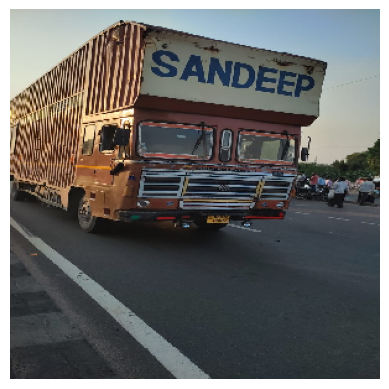

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
image_height = 224
image_width = 224
# Load the InceptionV3 model pre-trained on ImageNet data
model = InceptionV3(weights='imagenet')

# Load an image for prediction
img_path = '/content/Truck (1).jpg'
img = image.load_img(img_path, target_size=(299, 299))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the input for InceptionV3 model
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Decode the predictions to get class labels
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Print the top three predicted classes
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

# Display the image
#plt.title(f"Top Predictions: {decoded_predictions}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 54ms/step
Predicted Class: (1, 'Bus')


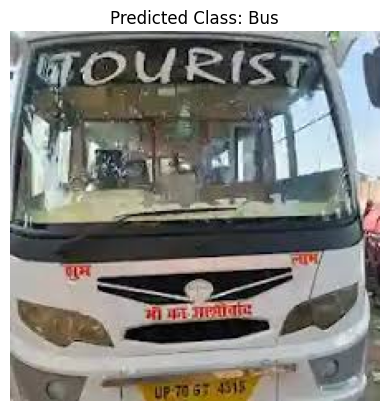

In [ ]:
img_path = '/content/images_b (1).jpeg'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 56ms/step
Predicted Class: (2, 'Car')


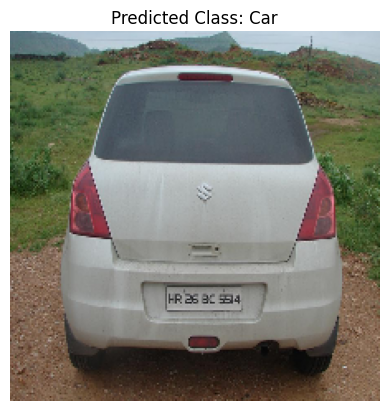

In [ ]:
img_path = '/content/img 095.PNG'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 55ms/step
Predicted Class: (1, 'Bus')


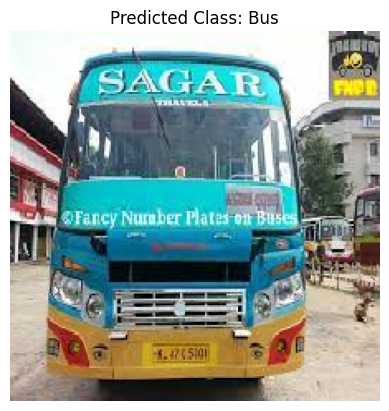

In [ ]:
img_path = '/content/download1.jpg'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 56ms/step
Predicted Class: (0, 'Auto')


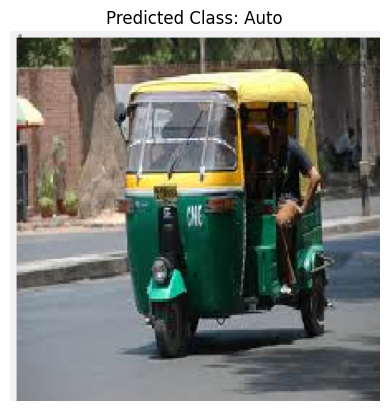

In [ ]:
img_path = '/content/img 128.PNG'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')